In [1]:
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\heine\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)
import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn import linear_model
import pickle
import subprocess
import networkx as nx
# import scipy.stats as stats

from Bio import SeqIO
from Bio import SeqFeature as sf
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq

import re

# from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')

what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
Added C:\Users\heine\github\expression_broad_data to path: 
['', 'C:\\Users\\heine\\Anaconda3\\python36.zip', 'C:\\Users\\heine\\Anaconda3\\DLLs', 'C:\\Users\\heine\\Anaconda3\\lib', 'C:\\Users\\heine\\Anaconda3', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Babel-2.5.0-py3.6.egg', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\heine\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\heine\\.ipython', 'C:\\Users\\heine\\github\\expression_broad_data']
I am about to import a library
I am importing io_library
what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
data process

# Identify all paralogs
subset paralogs by whole genome duplication. 

In [5]:
#Total number of WGD paralogs
ohnologs = pd.read_csv(data_processing_dir + os.path.normpath("ortholog_files_YGOB/ohnologs.csv"))
print('Total number of Ohnologs: ' + str(len(ohnologs)))

Total number of Ohnologs: 547


In [2]:
#Total number of KL genes that have a paralog in SCER
fname_cross_spec_comparison = data_processing_dir + os.path.normpath("20170817_klscpka/cross_species_compare_ASminus_ASplus_YPD.csv")
kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)

kl_sc_PKA_data_paralogs = kl_sc_PKA_data[kl_sc_PKA_data["N SCer Orthologs"]==2]

print('Total number of KL genes that map to a set of paralogs in S.Cer: ' + str(int(len(kl_sc_PKA_data_paralogs)/2)))

#Total of these that are WGD paralogs
ohnolog_set = set(ohnologs['Gene 1']) | set(ohnologs['Gene 2'])

non_ohnologs = set(kl_sc_PKA_data_paralogs['sc_genename']) - ohnolog_set
ohnologs_klac_orth = set(kl_sc_PKA_data_paralogs['sc_genename']) & ohnolog_set

print('KL genes that map to a set of Ohnologs: ' + str(int(len(ohnologs_klac_orth)/2)) + '\n' +
     'KL genes that map to a non Ohnolog paralog: ' + str(int(len(non_ohnologs))))


Total number of KL genes that map to a set of paralogs in S.Cer: 519


NameError: name 'ohnologs' is not defined

Apparently the ortholog mapping I am using only includes paralogs from the WGH.  I am sure there must be others.  I should probably investigate this at some stage. 

In [120]:
#What happens under PKA inhibition for SCer Genes that don't have a K.Lactis ortholog? 

ohnologs_no_kl_orth = ohnolog_set-set(kl_sc_PKA_data_paralogs['sc_genename'])

#Doesn't work - pickle breaks between gpu and my computer
#YPD data
# fname_comparison_data = "20170817_klscpka/ASminus_ASplus_YPD_comparison.pkl"
# with open(data_processing_dir + os.path.normpath(fname_comparison_data), 'rb') as pkl_in:
#      comparison_data = pickle.load(pkl_in)

sc_ypd_foldchange = pd.read_csv(data_processing_dir + os.path.normpath('20170817_klscpka/20170817_klscpka_DESEQ_YPD_t40_AsMinvAsPlus_SC.csv'))
sc_avg_counts = pd.read_csv(data_processing_dir + os.path.normpath('20170817_klscpka/20170817_klscpka_avg_counts_SC.csv'))
sc_avg_counts.rename(columns={'0':'sc_genename'},inplace=True)

sc_ypd_data = sc_ypd_foldchange.rename(columns= {'Unnamed: 0':'sc_genename'})
sc_ypd_data.set_index('sc_genename', inplace = True)
sc_ypd_data = sc_ypd_data.assign(SC_common_name = io_library.SC_common_name_lookup(sc_ypd_data.index))

sc_ypd_data = sc_avg_counts.join(sc_ypd_data, on='sc_genename')
sc_ypd_data.set_index('sc_genename', inplace = True)
sc_ypd_data


,AS_noNMPP1_SDC_t40_mean,AS_noNMPP1_SDC_t40_var,AS_yesNMPP1_SDC_t40_mean,AS_yesNMPP1_SDC_t40_var,WT_noNMPP1_SDC_t40_mean,WT_noNMPP1_SDC_t40_var,WT_yesNMPP1_SDC_t40_mean,WT_yesNMPP1_SDC_t40_var,AS_noNMPP1_YPD_t40_mean,AS_noNMPP1_YPD_t40_var,...,AS_noNMPP1_SDC_t20_var,AS_yesNMPP1_SDC_t20_mean,AS_yesNMPP1_SDC_t20_var,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,SC_common_name
sc_genename,,,,,,,,,,,,,,,,,,,,,
YAL012W,3.413158,0.014747,3.337415,0.008049,3.352534,0.013363,3.252958,0.000013,3.408142,0.000657,...,0.004576,3.370129,0.010604,3164.003504,-0.441366,0.278283,-1.586033,1.127318e-01,2.004965e-01,CYS3
YAL069W,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,YAL069W
YAL068W-A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121944,0.029740,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,YAL068W-A
YAL068C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.124758,0.046693,0.000000,NaN,NaN,NaN,NaN,NaN,PAU8
YAL067W-A,0.000000,0.000000,0.142101,0.060578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.144697,0.062812,0.145147,1.379840,4.080473,0.338157,7.352450e-01,8.303820e-01,YAL067W-A
YAL067C,0.352827,0.098438,0.709097,0.411962,1.129172,0.016701,1.179267,0.004345,0.572047,0.006683,...,0.058953,0.894348,0.050347,5.260742,0.754235,0.989719,0.762070,4.460184e-01,5.963246e-01,SEO1
YAL066W,0.000000,0.000000,0.142101,0.060578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.124758,0.046693,0.200705,1.379840,4.080473,0.338157,7.352450e-01,8.303820e-01,YAL066W
YAL065C,0.193503,0.112330,0.000000,0.000000,0.078784,0.018621,0.327041,0.013829,0.164679,0.081357,...,0.077942,0.144697,0.062812,0.686532,-1.104253,3.055574,-0.361390,7.178081e-01,8.282432e-01,YAL065C
YAL064W-B,0.000000,0.000000,0.000000,0.000000,0.078784,0.018621,0.000000,0.000000,0.061998,0.011531,...,0.000000,0.089721,0.024150,0.484299,1.205730,3.003989,0.401376,6.881432e-01,8.085897e-01,YAL064W-B


In [144]:
sc_ypd_data[sc_ypd_data['SC_common_name'].isin(['MSN2','MSN4'])][['AS_noNMPP1_YPD_t40_mean','AS_yesNMPP1_YPD_t40_mean']]

,AS_noNMPP1_YPD_t40_mean,AS_yesNMPP1_YPD_t40_mean
sc_genename,,
YKL062W,0.932825,1.448539
YMR037C,0.878076,1.113982


In [121]:
ohnologs_no_kl_orth_pairs = ohnologs[ohnologs['Gene 1'].isin(ohnologs_no_kl_orth)]

print('Pairs of paralogs in SC with no kl ortholog: ' + str(len(ohnologs_no_kl_orth_pairs)))

#Go through this and assign fold change to each one.  

new_data = {'gene1_LFC': [], 'gene1_avg_exp_noNMPP1': [],'gene1_avg_exp_yesNMPP1': [],
            'gene2_LFC': [], 'gene2_avg_exp_noNMPP1': [],'gene2_avg_exp_yesNMPP1': []}

for ind, row in ohnologs_no_kl_orth_pairs.iterrows(): 
    gene1 = row['Gene 1']
    new_data['gene1_LFC'].append(float(sc_ypd_data.loc[gene1]['log2FoldChange']))
    new_data['gene1_avg_exp_noNMPP1'].append(float(sc_ypd_data.loc[gene1]['AS_noNMPP1_YPD_t40_mean']))
    new_data['gene1_avg_exp_yesNMPP1'].append(float(sc_ypd_data.loc[gene1]['AS_yesNMPP1_YPD_t40_mean']))
    
    gene2 = row['Gene 2']
    new_data['gene2_LFC'].append(float(sc_ypd_data.loc[gene2]['log2FoldChange']))
    new_data['gene2_avg_exp_noNMPP1'].append(float(sc_ypd_data.loc[gene2]['AS_noNMPP1_YPD_t40_mean']))
    new_data['gene2_avg_exp_yesNMPP1'].append(float(sc_ypd_data.loc[gene2]['AS_yesNMPP1_YPD_t40_mean']))

ohnologs_no_kl_orth_pairs.assign(**new_data)[['Gene Name 1','gene1_LFC','gene1_avg_exp_noNMPP1','gene1_avg_exp_yesNMPP1','Gene Name 2', 'gene2_LFC','gene2_avg_exp_noNMPP1','gene2_avg_exp_yesNMPP1']].sort_values(by='gene1_LFC')

# for ind, column in enumerate(columns): 
#     a[column] = [row[ind] for row in b]

Pairs of paralogs in SC with no kl ortholog: 28


,Gene Name 1,gene1_LFC,gene1_avg_exp_noNMPP1,gene1_avg_exp_yesNMPP1,Gene Name 2,gene2_LFC,gene2_avg_exp_noNMPP1,gene2_avg_exp_yesNMPP1
520,SPO19,-4.840507,0.713965,0.000000,YOR214C,2.420921,0.249763,0.837610
534,RPL20A,-3.936965,3.412258,2.367661,RPL20B,-4.111787,3.301923,2.202816
543,ATR1,-2.128023,2.374841,1.862896,YMR279C,-1.493332,0.720556,0.498756
435,RPL41A,-2.036833,3.657479,3.178033,RPL41B,-1.805427,3.035567,2.703081
417,TIR3,-1.511669,2.460936,2.132716,TIR2,0.264392,1.615583,1.816379
215,MIG3,-1.339809,1.399376,1.173717,MIG2,-2.603948,1.995060,1.357922
190,BAP2,-1.192563,2.766405,2.572179,BAP3,-1.564176,2.917730,2.581011
175,YDL012C,-0.955096,2.531284,2.382145,YBR016W,1.006656,2.482495,2.920191
293,RSC3,-0.903158,1.856831,1.758987,RSC30,0.186450,0.735845,0.823483
31,LCB3,-0.753349,2.341170,2.248597,YSR3,0.434324,1.766047,2.025983


HXT1 and 6.  6 low expression - expressed a bit more.  1 high expression - decreased significantly. 
YPR1 and GCY1:  GCY1 highly expressed, YPR 1 induced a bit. 
HXT7/HXT4: 7 up, 4 down.  
YOR186W/YLR297W: 186W up 297W up a bit. 297W goes from nucleus to the vacuole underdna rep stress.  186W localized to vacuole.  
SPO19: one up one down, but not very highly expressed. Sporulation

both: 
GPX1/HYR1: GPX - oxidative stress, HYR1 oxidative stress sensor
HOR7/DDR2: DDR2 very highly expressed under stress.  function really not known (SGD)
PDR5/PDR15: ABC transporter
YBR284W/YJL070C: function not clear. 
SPS100/YGP1: SPS100 goes from barely expressed to high.  YGP1 already relatively highly expressed gets higher. Cell wall proteins.  SPS100 sporulation related. 

All jointly repressed: 
534	RPL20A	-3.936965	3.412258	2.367661	RPL20B	-4.111787	3.301923	2.202816
543	ATR1	-2.128023	2.374841	1.862896	YMR279C	-1.493332	0.720556	0.498756
435	RPL41A	-2.036833	3.657479	3.178033	RPL41B	-1.805427	3.035567	2.703081
215	MIG3	-1.339809	1.399376	1.173717	MIG2	-2.603948	1.995060	1.357922
190	BAP2	-1.192563	2.766405	2.572179	BAP3	-1.564176	2.917730	2.581011

Mig2/Mig3 cause glucose repression.  
ATR1 is a drug pump - SGD says it increases under stress.  Paralog might be a boron transporter- also should be induced (SGD)  but doesn't seem to be here. 
BAP2/3: amino acid uptake (really not decreased that much) 

In [141]:
#For SC genes that have no KL orthologs, what genes change drastically under PKA inhibition?  
#Already looked at paralogs above. 

sc_no_kl_orths = set(sc_avg_counts['sc_genename'])-set(kl_sc_PKA_data['sc_genename'])

sc_no_kl_orths_no_paralogs = sc_no_kl_orths - (set(ohnologs_no_kl_orth_pairs['Gene 1']) | set(ohnologs_no_kl_orth_pairs['Gene 2']))           
                                               
print("There are {} sc genes with no kl ortholog.  Of those {} do not have ohnologs".format(len(sc_no_kl_orths), len(sc_no_kl_orths_no_paralogs)))

columns_to_view = ['SC_common_name', 'log2FoldChange', 'AS_noNMPP1_YPD_t40_mean', 'AS_yesNMPP1_YPD_t40_mean']

sc_ypd_data_sc_only = sc_ypd_data.loc[sc_no_kl_orths]

sc_ypd_data_sc_only_pka_change = sc_ypd_data_sc_only[abs(sc_ypd_data_sc_only['log2FoldChange'])>2.0]

print("Of the {} sc genes with no kl ortholog, {} of them have fold change greater than 2.0 (up or down) under PKA inhibition.  20 of those are paralogs".format(
        len(sc_no_kl_orths), len(sc_ypd_data_sc_only_pka_change)))

sc_ypd_data_sc_only_pka_change.sort_values(by='log2FoldChange')[columns_to_view]



There are 1724 sc genes with no kl ortholog.  Of those 1668 do not have ohnologs
Of the 1724 sc genes with no kl ortholog, 336 of them have fold change greater than 2.0 (up or down) under PKA inhibition.  20 of those are paralogs


,SC_common_name,log2FoldChange,AS_noNMPP1_YPD_t40_mean,AS_yesNMPP1_YPD_t40_mean
sc_genename,,,,
YOR309C,YOR309C,-6.754461,2.443750,0.637542
YGL168W,HUR1,-6.738577,1.198944,0.000000
YBR092C,PHO3,-5.975478,2.395164,0.832014
YDL039C,PRM7,-5.844456,2.760269,1.187281
YDL227C,HO,-5.497170,2.999891,1.497682
YBR191W-A,YBR191W-A,-5.068049,1.881674,0.954339
YDR281C,PHM6,-4.843624,1.742183,0.546998
YPL130W,SPO19,-4.840507,0.713965,0.000000
YMR042W,ARG80,-4.802050,0.594620,0.000000


PAI3: Proteinase A inhibitor
GPG1: gamma subunit interacting with GPR1
RRT1: unknown function - deletion effect ribosomal dna transcription
AMS1: Oligosaccharide degradation.  
DIA3: pseudohyphal growth
HSP31: converts methylglyoxal to D-lactate;
PDC6: amino acid catabolism

Probably just overlapping HXK1:
YFR052C-A	YFR052C-A	4.902003	2.239221	3.865268
Probably just overlapping SYM1 (mitochondrial protein)
YLR252W	YLR252W	4.602415	1.455752	2.954681

Probably just overlapping PMR1
YGL168W	HUR1	-6.738577	1.198944	0.000000

## Histogram of fold change under PKA inhibition for Paralogs and non-Paralogs

<IPython.core.display.Javascript object>


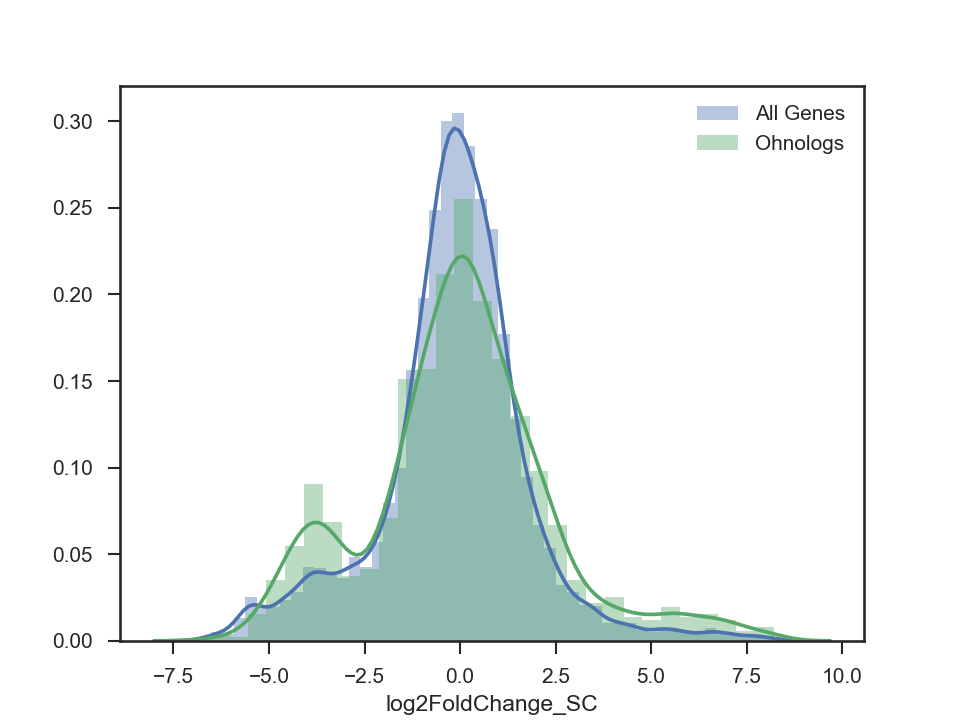

In [31]:

fig, ax = plt.subplots()

sns.distplot(kl_sc_PKA_data[~np.isnan(kl_sc_PKA_data['log2FoldChange_SC'])]['log2FoldChange_SC'], ax = ax, label = "All Genes")
sns.distplot(kl_sc_PKA_data_paralogs[~np.isnan(kl_sc_PKA_data_paralogs['log2FoldChange_SC'])]['log2FoldChange_SC'], ax = ax, label = "Ohnologs")

ax.legend()


### Show fold change scatter for K.Lac and S.Cer and identify Orthologs within scatter plot. 

In [21]:
kl_sc_PKA_data
hover_text = []
for ind, row in kl_sc_PKA_data.iterrows():
    hover_text.append(('{SC_common_name}<br>').format(SC_common_name=row['SC_common_name']))

titles = {1: 'One S.Cer ortholog ', 2: 'Two S.Cer orthologs '}
colors = {1: 'grey', 2: 'red'}
fig_data = [
  		{
  			'x': kl_sc_PKA_data[kl_sc_PKA_data['N SCer Orthologs']==NN]['log2FoldChange_KL'], 
        	'y': kl_sc_PKA_data[kl_sc_PKA_data['N SCer Orthologs']==NN]['log2FoldChange_SC'], 
        	'text': kl_sc_PKA_data[kl_sc_PKA_data['N SCer Orthologs']==NN]['SC_common_name'], 
        	'mode': 'markers', 
            'marker': {
                'opacity': 0.5,
                'color': colors[NN]
                },
        	'name': titles[NN] } for NN in [1,2]]


fig = {
    'data': fig_data,
    'layout': {
        'xaxis': {'title': 'K.Lactis LFC 4uM NMPP1 v.s. no drug'},
        'yaxis': {'title': 'S.Cerevisiae LFC 4uM NMPP1 v.s. no drug'}
    }
}



py.iplot(fig, filename='KL_SC_foldchange_paralog_overlay')

In [9]:
#Table showing percentage of ohnologs in all genes v.s. SC expressed genes (P.value?) 
print(len(kl_sc_PKA_data[kl_sc_PKA_data['N SCer Orthologs']==2]))
print(len(kl_sc_PKA_data))
1038/4976

1038
4976


0.20860128617363344

# Subsets comparing K.Lac and S.Cer expression for differentially induced paralogs. 

In [7]:
#build a dataframe that has all SC paralogs paired up with log fold change and mean expression columns.  Also has K.Lactis log fold change and mean expression columns. 

ohnologs_expression_gene1 = pd.merge(ohnologs, kl_sc_PKA_data_paralogs, how = 'inner', left_on = 'Gene 1', right_on = 'sc_genename')
ohnologs_expression = pd.merge(ohnologs_expression_gene1, kl_sc_PKA_data_paralogs, how = 'inner', left_on = 'Gene 2', right_on = 'sc_genename', suffixes = ['_gene1', '_gene2'])
#Drop Gene 1 and Gene 2 columns
ohnologs_expression.drop(['Gene 1', 'Gene 2'], axis = 1, inplace = True)
#Rename Gene Name 1 and Gene Name 2 columns
ohnologs_expression.rename(columns = {'Gene Name 1':'SC_common_name_YGOB_gene1','Gene Name 2':'SC_common_name_YGOB_gene2'}, inplace = True)

In [8]:
YGOB_common_name = ohnologs_expression[ohnologs_expression['SC_common_name_gene1'].isnull()].copy()['SC_common_name_YGOB_gene1']
print('There are {} genes in the gene1 column that have no common name from SGD. Overwriting with YGOB common name'.format(len(YGOB_common_name)))
print(YGOB_common_name)
ohnologs_expression.loc[YGOB_common_name.index,'SC_common_name_gene1']=list(YGOB_common_name)
ohnologs_expression[ohnologs_expression['SC_common_name_gene1'].isnull()]

There are 2 genes in the gene1 column that have no common name from SGD. Overwriting with YGOB common name
218      SDC25
465    YDR134C
Name: SC_common_name_YGOB_gene1, dtype: object


,Number,Ancestor,SC_common_name_YGOB_gene1,SC_common_name_YGOB_gene2,AA %id,Length Ratio,N SCer Orthologs_gene1,kl_genename_gene1,sc_genename_gene1,baseMean_KL_gene1,...,padj_SC_gene2,rlog_AS_noNMPP1_YPD_t40_mean_SC_gene2,rlog_AS_yesNMPP1_YPD_t40_mean_SC_gene2,rlog_AS_noNMPP1_YPD_t40_var_SC_gene2,rlog_AS_yesNMPP1_YPD_t40_var_SC_gene2,raw_AS_noNMPP1_YPD_t40_mean_SC_gene2,raw_AS_yesNMPP1_YPD_t40_mean_SC_gene2,raw_AS_noNMPP1_YPD_t40_var_SC_gene2,raw_AS_yesNMPP1_YPD_t40_var_SC_gene2,SC_common_name_gene2


In [9]:

column_prefixes = [item[:-5] for item in list(ohnologs_expression.columns) if item[-5:]=='gene1']
columns_to_keep = [item for item in list(ohnologs_expression.columns) if item[-5:-1] != 'gene']
# columns_by_gene_no = {'gene1': ['Gene 1', 'Gene Name 1', 'log2FoldChange_SC_gene1'], 'gene2': ['Gene 2', 'Gene Name 2',  'log2FoldChange_SC_gene2']}

#make new columns: 
# new_column_list = ['Gene low', 'Gene Name low', 'log2FoldChange_SC_low', 'Gene high', 'Gene Name high', 'log2FoldChange_SC_high']

new_columns_data = []

for index, row in ohnologs_expression.iterrows():
    #Decide if gene1 or gene2 is low expression
    if row['log2FoldChange_SC_gene1']<row['log2FoldChange_SC_gene2']:
        low_gene = 'gene1'
        high_gene = 'gene2'
    elif  row['log2FoldChange_SC_gene1']>row['log2FoldChange_SC_gene2']:
        low_gene = 'gene2'
        high_gene = 'gene1'
    else:
        print('problems with {} and {}'.format(row['SC_common_name_gene1'],row['SC_common_name_gene2']))
    
    low_columns = [prefix + low_gene for prefix in column_prefixes]
    high_columns = [prefix + high_gene for prefix in column_prefixes]
    new_columns_data.append([row[column] for column in low_columns] + [row[column] for column in high_columns])

#Start with kept columns
ohnologs_expression_sorted = ohnologs_expression.loc[:,columns_to_keep]

#this seems to be looping through inefficiently
new_column_list = [prefix + 'low' for prefix in column_prefixes] + [prefix + 'high' for prefix in column_prefixes]


new_data = pd.DataFrame(new_columns_data, index = ohnologs_expression_sorted.index, columns = new_column_list)

ohnologs_expression_sorted = pd.concat([ohnologs_expression_sorted,new_data], axis = 1)


problems with SDC25 and CDC25
problems with YGR273C and YMR295C
problems with YDR134C and CCW12


In [101]:
#Plot high v.s. low fold change as a scatter plot. 
hover_text = []
for ind, row in ohnologs_expression_sorted.iterrows():
    #(row['Gene Name 1'],row['topologies_gene1'],row['Gene Name 2'], row['topologies_gene2'])
    hover_text.append('Low Paralog: {}<br>High Paralog: {}'.format(row['SC_common_name_low'],row['SC_common_name_high']))

trace = pygo.Scatter(
            x= ohnologs_expression_sorted['log2FoldChange_SC_low'],
            y= ohnologs_expression_sorted['log2FoldChange_SC_high'], 
            mode= 'markers',
            text= hover_text 
            )

layout = pygo.Layout(
    #title= 'topology for ohnologs',
    hovermode= 'closest',
    xaxis= {'title':'Low Paralog Log2 Fold Change after 1NMPP1', 'range' : [-8.4,8.4]},
    yaxis= {'title':'High Paralog Log2 Fold Change after 1NMPP1', 'range' :  [-8.4,8.4]}
    )
    
fig= pygo.Figure(data=[trace], layout=layout)

py.iplot(fig, filename='Low v.s. High Paralog Expression')




In [10]:
#Assign sc threshold groups
high_threshold_SC = 2.5
low_threshold_SC = -high_threshold_SC
ohnologs_expression_sorted = ohnologs_expression_sorted.assign(threshold_group_SC = lambda x: io_library.threshold_group_SC_series(x.log2FoldChange_SC_low,x.log2FoldChange_SC_high,high_threshold_SC, low_threshold_SC))

#Assign kl threshold groups
high_threshold_KL = high_threshold_SC
low_threshold_KL = low_threshold_SC
ohnologs_expression_sorted = ohnologs_expression_sorted.assign(threshold_group_KL = lambda x: io_library.threshold_group_KL_series(x.log2FoldChange_KL_low, high_threshold_KL, low_threshold_KL))


In [11]:
ohnologs_expression_sorted.to_csv(data_processing_dir + os.path.normpath('20170817_klscpka/20170817_ohnologs_sorted.csv'))

In [9]:
ohnologs_expression_sorted
columns_to_view = [ 'SC_common_name_YGOB_low', 'sc_genename_low','log2FoldChange_SC_low',
                   'SC_common_name_YGOB_high', 'sc_genename_high', 'log2FoldChange_SC_high',
                   'threshold_group_SC', 'threshold_group_KL',
                  'log2FoldChange_KL_low', 'AA %id', 'kl_genename_low']
ohnologs_expression_sorted[ohnologs_expression_sorted['SC_common_name_high'].isin(['GDH1','GDH3'])].loc[:,columns_to_view]

,SC_common_name_YGOB_low,sc_genename_low,log2FoldChange_SC_low,SC_common_name_YGOB_high,sc_genename_high,log2FoldChange_SC_high,threshold_group_SC,threshold_group_KL,log2FoldChange_KL_low,AA %id,kl_genename_low
379,GDH1,YOR375C,-3.521635,GDH3,YAL062W,2.46504,down_flat,flat,-0.50328,87%,KLLA0F00594g


In [76]:
#Bar chart showing expression groups  

expression_groups = ['up_flat','down_flat','up_down', 'flat_flat', 'down_down','up_up']
diff_color = 'rgba(252,170,89,1)'
same_color = 'rgba(12,12,12,0.4)'

#data_sets = {'All Paralogs': ohnologs_expression, 'Separated Paralogs': ohnologs_expression_separated}
data_set = ohnologs_expression_sorted
#traces = []

#for name, data_set in data_sets.items():

counts = data_set['threshold_group_SC'].value_counts()[expression_groups].fillna(0)
total_counts = sum(counts)
percentages = counts/total_counts*100

trace = pygo.Bar(
    x=expression_groups,
    y=percentages,
    text=['{} <br> {:2.0f}%'.format(item, item/total_counts*100) for item in list(counts)],
    textposition = 'auto',
    insidetextfont = {'color': 'white'},
    marker=dict(
        color=[diff_color, diff_color, diff_color,
               same_color, same_color, same_color])
    #name = name

    )

#traces.append(trace)
#data = traces

data = [trace]
layout = pygo.Layout(
    barmode='group',
    yaxis = {'title': 'Pct Ohnolog Pairs'}
)

fig = pygo.Figure(data=data, layout=layout)
py.iplot(fig, filename='paralog_expression_groups')




In [140]:
#Bar chart showing KL expressionin separated genes by group

expression_groups = ['up_flat','down_flat','up_down', 'flat_flat', 'down_down','up_up']
kl_foldchange_groups = ['up', 'flat', 'down']

#build dataframe with counts for each level

data_set = ohnologs_expression_sorted #ohnologs_expression_separated

count_data = {}
for group in kl_foldchange_groups: 

    kl_group = data_set[data_set['threshold_group_KL']==group]

    counts = kl_group['threshold_group_SC'].value_counts()[expression_groups].fillna(0)

    count_data[group] = counts

count_data_df = pd.DataFrame(count_data, index = expression_groups)

traces = []

for group in kl_foldchange_groups:

    counts = count_data_df[group]
    #total_counts = sum(counts)
    #percentages = counts/total_counts*100
    
    trace = pygo.Bar(
        x=expression_groups,
        y=counts,
        text= counts,
        textposition = 'auto',
        insidetextfont = {'color': 'white'},
        name = 'kl exp ' + group
    #     marker=dict(
    #             color='rgb(158,202,225)',
    #             line=dict(
    #                 color='rgb(8,48,107)',
    #                 width=1.5),
    #             ),
    #     opacity=0.6
        )
    
    traces.append(trace)

data = traces
layout = pygo.Layout(
    barmode='stack',
    xaxis = {'title': 'SCer paralog expression groups'},
    yaxis = {'title': 'Number of paralog pairs'}
)

fig = pygo.Figure(data=data, layout=layout)
py.iplot(fig, filename='paralog_expression_groups_kl_exp')


In [105]:
SGD_features = io_library.read_SGD_features()
SGD_features[2]['YAL040C']

'G1 cyclin involved in cell cycle progression; activates Cdc28p kinase to promote G1 to S phase transition; plays a role in regulating transcription of other G1 cyclins, CLN1 and CLN2; regulated by phosphorylation and proteolysis; acetyl-CoA induces CLN3 transcription in response to nutrient repletion to promote cell-cycle entry; cell cycle arrest phenotype of the cln1 cln2 cln3 triple null mutant is complemented by any of human cyclins CCNA2, CCNB1, CCNC, CCND1, or CCNE1'

In [9]:
#functional enrichment of differential expression groups

#Load go slim terms
#Set up go term list and database: 
GO_aspect = 'P'
go_slims_aspect, go_term_list = io_library.load_goslim_data(GO_aspect)


In [124]:
#Table with descriptions for up_down and up_up
expression_groups = ['up_flat','down_flat','up_down', 'flat_flat', 'down_down','up_up']

for group in expression_groups: 

    data_set = ohnologs_expression_sorted[ohnologs_expression_sorted['threshold_group_SC']==group]

    #cycle through each paralog pair and make columns for 
    paralog_specific_data = ['sc_genename', 'SC_common_name', 'log2FoldChange_SC']

    #and only for one copy
    paralog_indep_data = ['threshold_group_SC','kl_genename_low','log2FoldChange_KL_low','threshold_group_KL']

    new_data = []

    for ind, row in data_set.iterrows():
        new_data.append([row[col+'_low'] for col in paralog_specific_data] + [row[col] for col in paralog_indep_data] )
        new_data.append([row[col+'_high'] for col in paralog_specific_data] + [row[col] for col in paralog_indep_data] )

    paralog_table = pd.DataFrame(new_data, columns = paralog_specific_data + paralog_indep_data)

    #add in columns
    description_list = []
    goterm_list = []
    for gene in paralog_table['sc_genename']:
        try: 
            description = SGD_features[2][gene]
        except KeyError: 
            print('description lookup failed for ' + gene)
            description = "Lookup Failed"
        description_list.append(description)
        goterm_list.append(", ".join(list(go_slims_aspect[go_slims_aspect['sc_genename'] == gene].loc[:,'GO_term'])))

    paralog_table['Description'] = description_list
    paralog_table['Go Slim Terms'] = goterm_list

    paralog_table.to_csv(data_processing_dir + os.path.normpath('20170817_klscpka/paralog_table_' + group + '.csv'))
    # 'Description'
    # 'Go Slim Terms'

description lookup failed for Scer_YGOB_SDC25
description lookup failed for Scer_YGOB_YDR134C


In [137]:
#go enrichment for all ohnologs
data_set =  ohnologs_expression_sorted

gene_set_list = list(data_set['sc_genename_low']) + list(data_set['sc_genename_high'])

background_genes = list(kl_sc_PKA_data['sc_genename'])

go_term_enrichment = io_library.go_term_enrichment(gene_set_list, background_genes, go_term_list, go_slims_aspect)

go_term_enrichment.to_csv(data_processing_dir + os.path.normpath('20170817_klscpka/paralog_group_enrichment_all_ohnologs.csv'))

The following missing genes are filtered out of the background set:
{'Scer_YGOB_Anc_7.495', 'Scer_RDN25-1', 'Scer_RDN18-1', 'Scer_YGOB_ADL119W', 'Scer_RDN58-1', 'Scer_YGOB_SDC25', 'Scer_RDN5-1', 'Scer_YGOB_YDR134C'}
The following missing genes are filtered out of the input set:
{'Scer_YGOB_SDC25', 'Scer_YGOB_YDR134C'}
not_yet_annotated term removed: no background genes


In [136]:
#go enrichment for groups with enough terms

expression_groups = ['up_flat','down_flat','up_down', 'flat_flat', 'down_down','up_up']

for group in expression_groups:

    data_set =  ohnologs_expression_sorted[ohnologs_expression_sorted['threshold_group_SC']==group]

    gene_set_list = list(data_set['sc_genename_low']) + list(data_set['sc_genename_high'])

    background_genes = list(kl_sc_PKA_data['sc_genename'])

    go_term_enrichment = io_library.go_term_enrichment(gene_set_list, background_genes, go_term_list, go_slims_aspect)
    
    go_term_enrichment.to_csv(data_processing_dir + os.path.normpath('20170817_klscpka/paralog_group_enrichment_' + group + '.csv'))

The following missing genes are filtered out of the background set:
{'Scer_YGOB_Anc_7.495', 'Scer_RDN25-1', 'Scer_RDN18-1', 'Scer_YGOB_ADL119W', 'Scer_RDN58-1', 'Scer_YGOB_SDC25', 'Scer_RDN5-1', 'Scer_YGOB_YDR134C'}
not_yet_annotated term removed: no background genes
The following missing genes are filtered out of the background set:
{'Scer_YGOB_Anc_7.495', 'Scer_RDN25-1', 'Scer_RDN18-1', 'Scer_YGOB_ADL119W', 'Scer_RDN58-1', 'Scer_YGOB_SDC25', 'Scer_RDN5-1', 'Scer_YGOB_YDR134C'}
not_yet_annotated term removed: no background genes
The following missing genes are filtered out of the background set:
{'Scer_YGOB_Anc_7.495', 'Scer_RDN25-1', 'Scer_RDN18-1', 'Scer_YGOB_ADL119W', 'Scer_RDN58-1', 'Scer_YGOB_SDC25', 'Scer_RDN5-1', 'Scer_YGOB_YDR134C'}
not_yet_annotated term removed: no background genes
The following missing genes are filtered out of the background set:
{'Scer_YGOB_Anc_7.495', 'Scer_RDN25-1', 'Scer_RDN18-1', 'Scer_YGOB_ADL119W', 'Scer_RDN58-1', 'Scer_YGOB_SDC25', 'Scer_RDN5-1', '

In [133]:

go_term_enrichment.sort_values('pvalue')

,N subset genes in goterm,N genes in subset,pct goterm in subset,pct go term in background,pct of go terms genes in subset,pvalue,genes,genes common name,oddsratio
generation of precursor metabolites and energy,24,144,0.166667,0.027979,0.172662,1.162930e-11,"{YMR145C, YER054C, YEL039C, YFR017C, YIL045W, ...","[NDE1, GIP2, CYC7, IGD1, PIG2, CDC19, CYC1, GL...",6.948201
nucleobase-containing small molecule metabolic process,22,144,0.152778,0.035829,0.123596,2.608637e-08,"{YMR145C, YLR354C, YEL039C, YHR163W, YOL059W, ...","[NDE1, TAL1, CYC7, SOL3, GPD2, URA10, CDC19, C...",4.852643
carbohydrate metabolic process,21,144,0.145833,0.034823,0.121387,7.444894e-08,"{YMR145C, YER054C, YFR017C, YOL059W, YAL038W, ...","[NDE1, GIP2, IGD1, GPD2, CDC19, PIG2, SKT5, GL...",4.732130
cellular respiration,9,144,0.062500,0.014694,0.123288,4.424678e-04,"{YJR048W, YEL039C, YLR164W, YNL052W, YKL148C, ...","[CYC1, CYC7, SHH4, COX5A, SDH1, SDH4, COX5B, S...",4.470320
cofactor metabolic process,13,144,0.090278,0.033615,0.077844,1.539532e-03,"{YJR049C, YCL040W, YGR248W, YMR145C, YGR256W, ...","[UTR1, GLK1, SOL4, NDE1, GND2, YEF1, NDE2, TAL...",2.852905
carbohydrate transport,4,144,0.027778,0.003221,0.250000,2.058359e-03,"{YHR096C, YKL038W, YCL040W, YDR345C}","[HXT5, RGT1, GLK1, HXT3]",8.842857
oligosaccharide metabolic process,4,144,0.027778,0.003623,0.222222,2.974719e-03,"{YMR105C, YML100W, YMR261C, YKL127W}","[PGM2, TSL1, TPS3, PGM1]",7.857143
transmembrane transport,12,144,0.083333,0.035829,0.067416,6.919332e-03,"{YGR243W, YOL092W, YGL104C, YGR239C, YBR241C, ...","[MPC3, YPQ1, VPS73, PEX21, YBR241C, HXT3, PEX1...",2.446374
lipid transport,6,144,0.041667,0.012480,0.096774,1.173718e-02,"{YPR149W, YNR047W, YMR079W, YFL042C, YCR091W, ...","[NCE102, FPK1, SEC14, LAM5, KIN82, LAM6]",3.440393
peroxisome organization,5,144,0.034722,0.009863,0.102041,1.728290e-02,"{YGR239C, YDL204W, YHR160C, YDL022W, YDR233C}","[PEX21, RTN2, PEX18, GPD1, RTN1]",3.611070


In [125]:
#Look at go terms for top SC Sig only genes
data_set = ohnologs_expression_sorted[ohnologs_expression_sorted['threshold_group_SC']=='up_up']
gene_set_list = list(data_set.sc_genename_low) + list(data_set.sc_genename_high)

go_term_df = io_library.go_terms_for_genelist(gene_set_list, go_slims_aspect, go_term_list)
go_term_df[['genes common name','N genes in goterm','N subset genes in goterm']]


,genes common name,N genes in goterm,N subset genes in goterm
carbohydrate metabolic process,"[GSY1, UGP1, GSY2, NTH2, NTH1]",198,5
cell morphogenesis,[HBT1],29,1
oligosaccharide metabolic process,"[NTH2, NTH1, UGP1]",27,3
conjugation,[HBT1],124,1
protein folding,"[SSA3, SSA4]",95,2
response to oxidative stress,"[GRX2, GRX1]",105,2
cellular respiration,"[MBR1, ISF1]",84,2
cell wall organization or biogenesis,[FMP45],198,1
meiotic cell cycle,"[YNL194C, FMP45]",287,2
response to heat,[SSA4],73,1


## Identify paralog sets of interest

In [52]:
#ohnologs_expression_sorted[ohnologs_expression_sorted['SC_common_name_high'].isin(['CDC25','SDC25'])]['SC_common_name_low']
ohnologs_expression_sorted[ohnologs_expression_sorted['SC_common_name_low'].isnull()]['SC_common_name_low']

,Number,Ancestor,AA %id,Length Ratio,SC_common_name_YGOB_low,N SCer Orthologs_low,kl_genename_low,sc_genename_low,baseMean_KL_low,log2FoldChange_KL_low,...,rlog_AS_yesNMPP1_YPD_t40_var_SC_high,raw_AS_noNMPP1_YPD_t40_mean_SC_high,raw_AS_yesNMPP1_YPD_t40_mean_SC_high,raw_AS_noNMPP1_YPD_t40_var_SC_high,raw_AS_yesNMPP1_YPD_t40_var_SC_high,SC_common_name_high,threshold_group_SC,threshold_group_KL,included_go_terms_low,included_go_terms_high
218,228,Anc_4.45,35%,0.79,SDC25,2,KLLA0D09306g,Scer_YGOB_SDC25,417.058835,1.212260,...,0.558748,1.927454,2.042149,0.002990,0.069411,CDC25,flat_flat,flat,None,None
465,490,Anc_8.301,75%,0.99,YDR134C,2,KLLA0F20031g,Scer_YGOB_YDR134C,47143.788864,-1.870207,...,0.073866,4.973242,4.856982,0.007943,0.007882,CCW12,flat_flat,flat,None,None


In [82]:
go_slims_aspect[go_slims_aspect['sc_common_name']=='MPC2']

,sc_genename,sc_common_name,sgd_ID,GO_aspect,GO_term,GO_term_ID,feature_type
18286,YHR162W,MPC2,S000001205,P,ion transport,GO:0006811,ORF|Verified
18287,YHR162W,MPC2,S000001205,P,transmembrane transport,GO:0055085,ORF|Verified


In [114]:
ohnologs_included[ohnologs_included['SC_common_name_low'].isin(['TDH2','TDH3'])].loc[:,['log2FoldChange_SC_low','log2FoldChange_SC_high']]

,log2FoldChange_SC_low,log2FoldChange_SC_high
270,-1.13687,0.27559


In [115]:
#Extract all paralogs pairs with go terms of interest
#add selected paralogs to the list 

go_terms_included = ['generation of precursor metabolites and energy', 
'nucleobase-containing small molecule metabolic process',
'carbohydrate metabolic process',
'cellular respiration',
'cofactor metabolic process',
'carbohydrate transport',
'oligosaccharide metabolic process',
'cellular amino acid metabolic process']


#Subset of go slims that have an included term
go_slims_included_terms = go_slims_aspect[go_slims_aspect['GO_term'].isin(go_terms_included)]

N_included = len(go_slims_included_terms)
print("There are {} instances of the included go terms in the go slim database".format(N_included))

#subset of included orthologs that have an ortholog

included_go_terms_low = []
included_go_terms_high = []

#list(go_slims_included_terms[go_slims_included_terms['sc_genename']=='YMR145C']['GO_term'])

#row[0]

for ind,row in ohnologs_expression_sorted.loc[:,['sc_genename_low','sc_genename_high']].iterrows():
    low_terms = list(go_slims_included_terms[go_slims_included_terms['sc_genename']==row[0]]['GO_term'])   
    if len(low_terms)==0: 
        included_go_terms_low.append(None)
    else:
        included_go_terms_low.append(low_terms)
        
    high_terms = list(go_slims_included_terms[go_slims_included_terms['sc_genename']==row[1]]['GO_term'])
    if len(high_terms)==0: 
        included_go_terms_high.append(None)
    else:
        included_go_terms_high.append(high_terms)
        

ohnologs_expression_sorted['included_go_terms_low']=included_go_terms_low
ohnologs_expression_sorted['included_go_terms_high']=included_go_terms_high

ohnologs_included = ohnologs_expression_sorted[(~ohnologs_expression_sorted['included_go_terms_low'].isnull()) | ~ohnologs_expression_sorted['included_go_terms_high'].isnull()]

                    
#extras of interest: 
# Regulator - 
# RGM1, USV1
# RGT1, EDS1 - transcription factors - important in glucose transport
# PSK1, PSK2 - protein Kinase - carbohydrate metabolism. 
# MSG5,
# TPK1, TPK3
# CDC25, SDC25
# DOT6, TOD6


# #control terms: 
# flat_flat: ALT1, ALT2, lipid metabolic process, response to starvation (some already present)
# up_up: (response to starvation ) (some already present)
# down_down: (cytoplasmic translation)




There are 1073 instances of the included go terms in the go slim database


In [3]:
goi_metabolic = [ 'CYC1', 'CYC7',
                 'COX5A', 'COX5B',
                 'NDE1', 'NDE2',
                 'SDH3', 'SHH3', 
                 'SDH1', 'YJL045W',
                 'SDH4', 'SHH4',
                 'GPM3', 'GPM2',
                 'MPC2', 'MPC3',
                 'INH1','STF1',
                 'URA5','URA10',
                 'CDC19','PYK2',
                 'UTR1','YEF1',
                 'TAL1','NQM1',
                 'GND1','GND2',
                 'SOL3','SOL4',
                 'SOL1','SOL2',   #not sure about these ones
                 'TKL1','TKL2',
                 'GPD2','GPD1',
                 'PIG1','GAC1',
                 'PIG2','GIP2',
                 'TSA1','TSA2',
                 'EMI2','GLK1',  #both of these go up but they are key enzymes and there seems to be a difference in scale
                 'GDH1','GDH3',
                 'URA7','URA8',
                 'HXK1','HXK2',
                 'RNR1','RNR3',
                 'ENO2','ENO1',
                 'CIT1','CIT2',
                 'PGM1','PGM2',
                 'LEU4','LEU9',
                 'APT1','APT2',
                 'ASN1','ASN2',
                 'GPP1','GPP2',
                 'GRS1','GRS2',
                 'HXT3','HXT5',
                 'IGD1','YOL024W',
                 'IRC15','LPD1',  #LPD1 is part of pyruvate dehydrogenase
                 'ISF1', 'MBR1',   #mitochondrial biogenesis regulation.  both go up, but MBR1 starts low and goes up higher. 
                 'PRO1','YHR033W',
                 'PSK1','PSK2',
                 'RMD9','YBR238C',
                 'SHC1','SKT5',
                 'TSL1','TPS3',  #both of these go up but TSL1 starts lower and goes higher
                 'RNR1','RNR3',    #Added after looking at resp data - RNR1 down, RNR3 flat
                 'YBR238C', 'RMD9', #added after looking at resp data - YBR238C down, RMD9 flat. RMD9 essential for gly growth
                 'YDR341C', 'MSR1' #Added after looking at resp data.  YDR341C repressed, MSR1 flat. 
                ]
                

goi_regulator = ['SIP2','GAL83',
                'RGM1','USV1',
                'RGT1','EDS1',
                'MSG5','SDP1',
                'TPK1','TPK3',
                'RAS1','RAS2',
                'SDC25','CDC25',
                'DOT6','TOD6',
                'MSN2','MSN4']

goi_controls = ['RPL16A','RPL16B',
                'RPL24A','RPL24B',
                'RPL26A','RPL26B',  #up, up ?  seems odd
                'RPS1A','RPS1B',
                'RPL22A','RPL22B',
               'UGP1','YHL012W', #up up
               'NTH1','NTH2', #up up
                'GSY1','GSY2',#up up 
                 'GLG2','GLG1', #up up
                'RGI1','RGI2',  #both of these go up - RGI2 expressed at much lower levels than RGI1
                'PYC1','PYC2', #A bit flat in my data 
                   'IMD3','IMD4' #down down
                ]

goi = goi_metabolic + goi_regulator + goi_controls
goi

['CYC1',
 'CYC7',
 'COX5A',
 'COX5B',
 'NDE1',
 'NDE2',
 'SDH3',
 'SHH3',
 'SDH1',
 'YJL045W',
 'SDH4',
 'SHH4',
 'GPM3',
 'GPM2',
 'MPC2',
 'MPC3',
 'INH1',
 'STF1',
 'URA5',
 'URA10',
 'CDC19',
 'PYK2',
 'UTR1',
 'YEF1',
 'TAL1',
 'NQM1',
 'GND1',
 'GND2',
 'SOL3',
 'SOL4',
 'SOL1',
 'SOL2',
 'TKL1',
 'TKL2',
 'GPD2',
 'GPD1',
 'PIG1',
 'GAC1',
 'PIG2',
 'GIP2',
 'TSA1',
 'TSA2',
 'EMI2',
 'GLK1',
 'GDH1',
 'GDH3',
 'URA7',
 'URA8',
 'HXK1',
 'HXK2',
 'RNR1',
 'RNR3',
 'ENO2',
 'ENO1',
 'CIT1',
 'CIT2',
 'PGM1',
 'PGM2',
 'LEU4',
 'LEU9',
 'APT1',
 'APT2',
 'ASN1',
 'ASN2',
 'GPP1',
 'GPP2',
 'GRS1',
 'GRS2',
 'HXT3',
 'HXT5',
 'IGD1',
 'YOL024W',
 'IRC15',
 'LPD1',
 'ISF1',
 'MBR1',
 'PRO1',
 'YHR033W',
 'PSK1',
 'PSK2',
 'RMD9',
 'YBR238C',
 'SHC1',
 'SKT5',
 'TSL1',
 'TPS3',
 'RNR1',
 'RNR3',
 'YBR238C',
 'RMD9',
 'YDR341C',
 'MSR1',
 'SIP2',
 'GAL83',
 'RGM1',
 'USV1',
 'RGT1',
 'EDS1',
 'MSG5',
 'SDP1',
 'TPK1',
 'TPK3',
 'RAS1',
 'RAS2',
 'SDC25',
 'CDC25',
 'DOT6',
 'TOD6',
 '

In [5]:
kl_sc_PKA_data.columns

Index(['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
       'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL',
       'rlog_AS_noNMPP1_YPD_t40_mean_KL', 'rlog_AS_yesNMPP1_YPD_t40_mean_KL',
       'rlog_AS_noNMPP1_YPD_t40_var_KL', 'rlog_AS_yesNMPP1_YPD_t40_var_KL',
       'raw_AS_noNMPP1_YPD_t40_mean_KL', 'raw_AS_yesNMPP1_YPD_t40_mean_KL',
       'raw_AS_noNMPP1_YPD_t40_var_KL', 'raw_AS_yesNMPP1_YPD_t40_var_KL',
       'baseMean_SC', 'log2FoldChange_SC', 'lfcSE_SC', 'stat_SC', 'pvalue_SC',
       'padj_SC', 'rlog_AS_noNMPP1_YPD_t40_mean_SC',
       'rlog_AS_yesNMPP1_YPD_t40_mean_SC', 'rlog_AS_noNMPP1_YPD_t40_var_SC',
       'rlog_AS_yesNMPP1_YPD_t40_var_SC', 'raw_AS_noNMPP1_YPD_t40_mean_SC',
       'raw_AS_yesNMPP1_YPD_t40_mean_SC', 'raw_AS_noNMPP1_YPD_t40_var_SC',
       'raw_AS_yesNMPP1_YPD_t40_var_SC', 'SC_common_name'],
      dtype='object')

In [5]:
columns_to_keep = ['SC_common_name','sc_genename','log2FoldChange_SC','raw_AS_noNMPP1_YPD_t40_mean_SC','pvalue_SC','raw_AS_yesNMPP1_YPD_t40_mean_SC','kl_genename','log2FoldChange_KL','raw_AS_noNMPP1_YPD_t40_mean_KL','raw_AS_yesNMPP1_YPD_t40_mean_KL','pvalue_KL' ]

goi_sets = {'metabolic': goi_metabolic, 'regulatory' : goi_regulator, 'control' : goi_controls}

goi_set_data_list = []
for label, goi_set in goi_sets.items(): 
    goi_orfs = io_library.SC_orf_lookup_by_name(goi_set)
    goi_set_data = kl_sc_PKA_data[kl_sc_PKA_data['sc_genename'].isin(goi_orfs)].loc[:,columns_to_keep]
    goi_set_data['category'] = label
    goi_set_data_list.append(goi_set_data)

goi_data = pd.concat(goi_set_data_list)
goi_data.to_csv(data_processing_dir + os.path.normpath('20170817_klscpka/goi_data.csv'))
# for gene in goi_metabolic: 
#     print(gene)

S.Cer orf for YJL045Wnot found
S.Cer orf for YOL024Wnot found
S.Cer orf for YHR033Wnot found
S.Cer orf for YBR238Cnot found
S.Cer orf for YBR238Cnot found
S.Cer orf for YDR341Cnot found
S.Cer orf for SDC25not found
S.Cer orf for YHL012Wnot found


In [118]:
print("{} metabolic gois, {} control gois, {} regulator gois, {} gois based on go slims".format(
    len(goi_metabolic),len(goi_controls),len(goi_regulator),2*len(ohnologs_included)))

print("gois not included in slim based list: ")
print(set(goi_metabolic + goi_controls + goi_regulator) - set(list(ohnologs_included['SC_common_name_high'])+list(ohnologs_included['SC_common_name_low'])))

print("slim gois not included in manual goi list: ")
print(set(list(ohnologs_included['SC_common_name_high'])+list(ohnologs_included['SC_common_name_low']))-set(goi_metabolic + goi_controls + goi_regulator))

varying = ohnologs_included[ohnologs_included['threshold_group_SC']!='flat_flat']
varying_list = list(varying['SC_common_name_low'])+list(varying['SC_common_name_high'])

print("varying slim based gois not included in manual goi list: ")
print(set(varying_list)-set(goi_metabolic + goi_controls + goi_regulator))


98 metabolic gois, 6 control gois, 18 regulator gois, 188 gois based on go slims
gois not included in slim based list: 
{'USV1', 'RPS26B', 'MPC3', 'CDC25', 'TPK3', 'GPM2', 'SDP1', 'RGM1', 'MSN4', 'MSN2', 'GAL83', 'RPS26A', 'MSG5', 'TOD6', 'STF1', 'RPL22B', 'SOL1', 'DOT6', 'GPM3', 'SDC25', 'SOL2', 'RPL22A', 'MPC2', 'INH1', 'TPK1', 'SIP2'}
slim gois not included in manual goi list: 
{'SER33', 'MTH1', 'PET9', 'ASK10', 'MSR1', 'GAL1', 'ALT1', 'BMH1', 'YDR341C', 'NMA1', 'MET32', 'SKS1', 'ADE16', 'OSM1', 'EXG1', 'SDT1', 'BCH1', 'KRE6', 'LYS20', 'RNR4', 'BUD7', 'VHS3', 'BAT2', 'STD1', 'MMF1', 'TDH2', 'REG2', 'BMH2', 'FOL3', 'RGC1', 'RNR2', 'APA1', 'RMA1', 'BAT1', 'YBR230W-A', 'GSC2', 'FAA4', 'NPP1', 'GAL3', 'NPP2', 'APE2', 'SPR1', 'ISU2', 'ADH1', 'IDP2', 'IRA2', 'TDH3', 'PCL6', 'GUP1', 'CHS6', 'NMA2', 'REG1', 'HMF1', 'SIS2', 'GUP2', 'PCL7', 'COQ8', 'PHM8', 'FAA1', 'SAK1', 'YMR085W', 'FRD1', 'IRA1', 'ADE17', 'STR2', 'VHS1', 'APA2', 'AAC3', 'PCL10', 'ALT2', 'SNF3', 'GFA1', 'AAP1', 'ADH5', 'YJL1

In [12]:
#filter down to goi set and save
goi = goi_metabolic + goi_regulator + goi_controls
ohnologs_goi = ohnologs_expression_sorted[ohnologs_expression_sorted['SC_common_name_low'].isin(goi)].copy()
# check that same result occurs if you do low or high
print("check to see if same number comes up whether you use low or high common name")
print(len(ohnologs_goi) == sum(ohnologs_goi['sc_genename_low']==ohnologs_expression_sorted[ohnologs_expression_sorted['SC_common_name_high'].isin(goi)]['sc_genename_low']))

ohnologs_goi.to_csv(data_processing_dir + os.path.normpath('20170817_klscpka/20170817_ohnologs_goi.csv'))

check to see if same number comes up whether you use low or high common name
True


In [132]:
ohnologs_goi[ohnologs_goi['SC_common_name_low'].isin(['RPL22A','RPL22B','RPS26A','RPS26B'])]

,Number,Ancestor,AA %id,Length Ratio,SC_common_name_YGOB_low,N SCer Orthologs_low,kl_genename_low,sc_genename_low,baseMean_KL_low,log2FoldChange_KL_low,...,rlog_AS_yesNMPP1_YPD_t40_var_SC_high,raw_AS_noNMPP1_YPD_t40_mean_SC_high,raw_AS_yesNMPP1_YPD_t40_mean_SC_high,raw_AS_noNMPP1_YPD_t40_var_SC_high,raw_AS_yesNMPP1_YPD_t40_var_SC_high,SC_common_name_high,threshold_group_SC,threshold_group_KL,included_go_terms_low,included_go_terms_high
444,469,Anc_8.31,81%,0.99,RPL22A,2,KLLA0D05181g,YLR061W,698.947027,-3.988285,...,0.044564,2.679127,1.897522,0.001273,0.006342,RPL22B,down_down,down,None,None
450,475,Anc_8.149,98%,1.00,RPS26B,2,KLLA0D05115g,YER131W,9112.906771,-5.206649,...,0.010182,3.887235,3.052372,0.001310,0.003045,RPS26A,down_down,down,None,None


## Separated expression 

In [ ]:

#filter to genes with separated expression
foldchange_separation = 3.5

ohnologs_expression_separated = ohnologs_expression[abs(ohnologs_expression['log2FoldChange_SC_gene1'] - ohnologs_expression['log2FoldChange_SC_gene2']) > foldchange_separation]

columns_to_view = ['Gene 1', 'Gene Name 1', 'kl_genename_gene1', 'Gene 2', 'Gene Name 2', 'kl_genename_gene2', 'log2FoldChange_SC_gene1', 'log2FoldChange_SC_gene2', 'threshold_group_SC','log2FoldChange_KL_gene1','threshold_group_KL']

ohnologs_expression_separated[columns_to_view]

In [6]:
genes = ['YBL067C', 'YBR014C', 'YBR104W', 'YBR117C', 'YBR147W', 'YBR169C', 'YBR210W', 'YBR242W', 'YBR284W', 'YCL011C', 'YCL040W', 'YDL042C', 'YDL079C', 'YDL085W']
#ohnologs_expression_separated[((ohnologs_expression_separated['SC_common_name_gene1'].isin(genes)) | (ohnologs_expression_separated['SC_common_name_gene2'].isin(genes)))]
ohnologs_expression[((ohnologs_expression['Gene 1'].isin(genes)) | (ohnologs_expression['Gene 2'].isin(genes)))].loc[:,columns_to_view]

,Gene 1,Gene Name 1,kl_genename_gene1,Gene 2,Gene Name 2,kl_genename_gene2,log2FoldChange_SC_gene1,log2FoldChange_SC_gene2,threshold_group_SC,log2FoldChange_KL_gene1,threshold_group_KL
5,YCL040W,GLK1,KLLA0C01155g,YDR516C,EMI2,KLLA0C01155g,4.160390,2.464130,up_up,2.178913,up
58,YCL011C,GBP2,KLLA0D05016g,YNL004W,HRB1,KLLA0D05016g,-0.339117,-0.885933,flat_flat,-0.633052,flat
114,YDL085W,NDE2,KLLA0E21891g,YMR145C,NDE1,KLLA0E21891g,7.299282,-1.401044,up_flat,-1.448779,flat
117,YDL079C,MRK1,KLLA0F17006g,YMR139W,RIM11,KLLA0F17006g,2.391988,2.342037,up_up,1.775492,flat
160,YBR147W,RTC2,KLLA0C03762g,YOL092W,YOL092W,KLLA0C03762g,5.373333,-2.279177,up_down,-1.517012,flat
165,YDL042C,SIR2,KLLA0F14663g,YOL068C,HST1,KLLA0F14663g,-1.516204,-0.815229,flat_flat,0.370661,flat
170,YBR014C,GRX7,KLLA0E17733g,YDL010W,GRX6,KLLA0E17733g,0.290985,-0.259277,flat_flat,1.361603,flat
188,YBR104W,YMC2,KLLA0B08503g,YPR058W,YMC1,KLLA0B08503g,-4.971720,-0.995521,down_flat,-0.523493,flat
189,YBR117C,TKL2,KLLA0B09152g,YPR074C,TKL1,KLLA0B09152g,7.553395,-3.322902,up_down,-1.125151,flat
336,YBR210W,ERV15,KLLA0C05478g,YGL054C,ERV14,KLLA0C05478g,-0.445278,0.275750,flat_flat,0.041848,flat


In [43]:
genes = ['SOL4','GND1','TKL1','TAL1','HXK2','GPM2','ENO1','CDC19','CIT2','SDH1','SDH3','SDH4', 'LPD1']
#ohnologs_expression_separated[((ohnologs_expression_separated['SC_common_name_gene1'].isin(genes)) | (ohnologs_expression_separated['SC_common_name_gene2'].isin(genes)))]
ohnologs_expression[((ohnologs_expression['SC_common_name_gene1'].isin(genes)) | (ohnologs_expression['SC_common_name_gene2'].isin(genes)))].loc[:,columns_to_view]

,Gene 1,Gene Name 1,kl_genename_gene1,Gene 2,Gene Name 2,kl_genename_gene2,log2FoldChange_SC_gene1,log2FoldChange_SC_gene2,threshold_group_SC,log2FoldChange_KL_gene1,threshold_group_KL
60,YCR005C,CIT2,KLLA0F12760g,YNR001C,CIT1,KLLA0F12760g,-2.464709,2.403591,up_down,0.581082,flat
122,YKL141W,SDH3,KLLA0E12123g,YMR118C,SHH3,KLLA0E12123g,1.507281,6.163424,up_flat,0.499448,flat
168,YDL021W,GPM2,KLLA0C04081g,YOL056W,GPM3,KLLA0C04081g,5.378055,-0.497227,up_flat,1.763859,flat
189,YBR117C,TKL2,KLLA0B09152g,YPR074C,TKL1,KLLA0B09152g,7.553395,-3.322902,up_down,-1.125151,flat
213,YFR053C,HXK1,KLLA0D11352g,YGL253W,HXK2,KLLA0D11352g,5.119539,-3.237243,up_down,-0.010172,flat
233,YGR043C,NQM1,KLLA0A02607g,YLR354C,TAL1,KLLA0A02607g,6.817958,-0.212188,up_flat,-0.307250,flat
258,YGR256W,GND2,KLLA0A09339g,YHR183W,GND1,KLLA0A09339g,7.143522,-1.190240,up_flat,0.394234,flat
259,YGR254W,ENO1,KLLA0A09185g,YHR174W,ENO2,KLLA0A09185g,2.299404,-0.975982,up_flat,0.559521,flat
260,YGR248W,SOL4,KLLA0A05390g,YHR163W,SOL3,KLLA0A05390g,7.194901,-0.150099,up_flat,1.734949,flat
276,YJL045W,YJL045W,KLLA0D04444g,YKL148C,SDH1,KLLA0D04444g,5.551200,1.251018,up_flat,-0.204395,flat


In [13]:
len(list(ohnologs_expression_separated.sc_genename_gene1) + list(ohnologs_expression_separated.sc_genename_gene2))

162

In [14]:
#Go term enrichment of these 81 genes. 

#Load go slim terms
#Set up go term list and database: 
GO_aspect = 'P'
go_slims_aspect, go_term_list = io_library.load_goslim_data(GO_aspect)

#Look at go terms for top SC Sig only genes
gene_set_list = list(ohnologs_expression_separated.sc_genename_gene1) + list(ohnologs_expression_separated.sc_genename_gene2)
go_term_df = io_library.go_terms_for_genelist(gene_set_list, go_slims_aspect, go_term_list)
go_term_df[['genes common name','N genes in goterm','N subset genes in goterm']]



,genes common name,N genes in goterm,N subset genes in goterm
response to chemical,"[MSG5, TSA2, DAL80, TSA1, GND1, NQM1, GZF3, USV1]",446,8
regulation of protein modification process,"[SDP1, MSG5, FPR4, LRE1]",111,4
nucleobase-containing small molecule metabolic process,"[URA5, RNR1, RNR3, TKL2, SDH1, TAL1, URA10, GP...",198,24
response to heat,[GAC1],73,1
oligosaccharide metabolic process,"[TPS3, PGM1, TSL1, PGM2]",27,4
endocytosis,"[YPT53, VPS21, SDS24]",98,3
meiotic cell cycle,"[SHC1, FPR3, YOR338W, GAC1, SEC14]",287,5
cellular ion homeostasis,"[MMT1, TMN2, MMT2, PGM2, EMP70, SLF1]",128,6
rRNA processing,"[GSP1, SSF1]",311,2
response to oxidative stress,"[TSA1, GND1, NQM1, TSA2]",105,4


In [25]:
background_genes = list(kl_sc_PKA_data['sc_genename'])

go_term_enrichment = io_library.go_term_enrichment(gene_set_list, background_genes, go_term_list, go_slims_aspect)

go_term_enrichment

I am importing io_library
what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
data processing dir is C:\Users\heine\github\expression_broad_data\expression_data\
The following missing genes are filtered out of the background set:
{'Scer_YGOB_SDC25', 'Scer_YGOB_Anc_7.495', 'Scer_RDN18-1', 'Scer_RDN58-1', 'Scer_YGOB_YDR134C', 'Scer_RDN5-1', 'Scer_YGOB_ADL119W', 'Scer_RDN25-1'}
not_yet_annotated term removed: no background genes


In [28]:
pval_cutoff = 0.1
go_term_df[go_term_df['pvalue']<pval_cutoff].loc[:,['pvalue','N subset genes in goterm','pct goterm in subset',
                   'pct go term in background','pct of go terms genes in subset','genes common name']]

,pvalue,N subset genes in goterm,pct goterm in subset,pct go term in background,pct of go terms genes in subset,genes common name
nucleobase-containing small molecule metabolic process,1.231394e-08,24,0.148148,0.035829,0.134831,"[URA5, RNR1, RNR3, TKL2, SDH1, TAL1, URA10, GP..."
oligosaccharide metabolic process,4.492497e-03,4,0.024691,0.003623,0.222222,"[TPS3, PGM1, TSL1, PGM2]"
endosomal transport,8.195451e-02,6,0.037037,0.018116,0.066667,"[GGA2, GGA1, ELO2, VPS21, YPT53, EMP70]"
carbohydrate transport,3.125448e-03,4,0.024691,0.003221,0.250000,"[HXK1, HXT3, HXT5, HXK2]"
cell wall organization or biogenesis,3.823454e-02,11,0.067901,0.036232,0.061111,"[SDP1, HSP150, SKT5, SAC7, PIR3, PRS4, PRS2, M..."
generation of precursor metabolites and energy,3.866919e-07,19,0.117284,0.027979,0.136691,"[CYC7, PIG2, GIP2, SHH4, PGM1, HXK1, SDH4, GAC..."
lipid transport,1.969214e-02,6,0.037037,0.012480,0.096774,"[PRY1, FAT3, FAA4, SEC14, FAA1, PRY2]"
cofactor metabolic process,1.847940e-04,16,0.098765,0.033615,0.095808,"[TKL1, GPD1, HXK1, FAA4, TKL2, SOL4, TAL1, GND..."
ion transport,9.788079e-02,11,0.067901,0.043076,0.051402,"[YMC1, RTC2, FAT3, PRM6, KCH1, MPC3, FAA4, SEC..."
transmembrane transport,1.637629e-02,12,0.074074,0.035829,0.067416,"[RTC2, HXT3, PEX21, KCH1, PRM6, MPC3, GPD1, YM..."


In [197]:
AB

,A,B
0,-2.5,2.2
1,1.0,4.1


In [203]:




df = pd.DataFrame([[-2.5,2.2], [1.0,4.1]], columns =['A','B'] )
df

#io_library.threshold_group_series(A,B, high_threshold, low_threshold)

# io_library.threshold_group(b,a,high_threshold, low_threshold)

# #input: a, b, high_threshold, low_threshold
# #output: group - either {'up_up', 'up_flat','up_down','flat_flat', 'down_flat','down_down'}

# a_sign = io_library.threshold_sign(a, high_threshold, low_threshold)
# b_sign = io_library.threshold_sign(b, high_threshold, low_threshold)

# sign_sum = a_sign+b_sign

# if sign_sum ==2:
#     group = 'up_up'
# elif sign_sum == -2: 
#     group = 'down_down'
# elif sign_sum == 1: 
#     group = 'up_flat'
# elif sign_sum == -1: 
#     group = 'down_flat'
# elif sign_sum == 0:
#     if a_sign-b_sign == 0:
#         group = 'flat_flat'
#     else: 
#         group = 'up_down'
# else: 
#     print('Error - did not assign group')

# return group



,A,B,new
0,-2.5,2.2,up_down
1,1.0,4.1,up_flat


In [ ]:
#bar chart

x = ['Product A', 'Product B', 'Product C']
y = [20, 14, 23]
y2 = [16,12,27]

trace1 = go.Bar(
    x=x,
    y=y,
    text=y,
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

trace2 = go.Bar(
    x=x,
    y=y2,
    text=y2,
    textposition = 'auto',
    marker=dict(
        color='rgb(58,200,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6
)

data = [trace1,trace2]

py.iplot(data, filename='grouped-bar-direct-labels')




In [19]:
ohnologs_expression[ohnologs_expression['Gene Name 1']=='ADH5'][columns_to_view]



,Gene 1,Gene Name 1,kl_genename_gene1,Gene 2,Gene Name 2,kl_genename_gene2,log2FoldChange_SC_gene1,log2FoldChange_SC_gene2,threshold_group_SC,log2FoldChange_KL_gene1,threshold_group_KL
163,YBR145W,ADH5,KLLA0F21010g,YOL086C,ADH1,KLLA0F21010g,0.148592,0.099784,flat_flat,0.096766,flat


In [18]:
# from io import StringIO
# from Bio import Phylo


In [16]:

kl_sc_PKA_data[kl_sc_PKA_data['SC_common_name'].isin(['RPL22A','RPL22B'])].loc[:,['log2FoldChange_SC','raw_AS_noNMPP1_YPD_t40_mean_SC','raw_AS_yesNMPP1_YPD_t40_mean_SC']]


,log2FoldChange_SC,raw_AS_noNMPP1_YPD_t40_mean_SC,raw_AS_yesNMPP1_YPD_t40_mean_SC
4936,-3.041141,2.679127,1.897522
4937,-4.806814,3.523597,2.224552
